# Zillow Clustering Project
* Chenchen Feng
* 08/09/2022

## Project Goals
* The goal is to find the key drivers of log error for single-family properties on Zillow, then make recommendations to help the data science team have a better prediction on the future log error.

## Project Description
* In this report, we will analyze the Zillow 2017 single-family property transaction data, incorporate clustering methodologies and use the regression machine learning method to develop a model to prediction of the log error base on the selected features. Then give out the recommendations about how to improve the predictions for the log error and my next steps.

## Initial Questions

1. Does the log error related by location?

2. Why orange county has the biggest log error? is it because of the house price in orange county is different than average?

3. If the Orange county average price could impact log error, what about the relationship overall house value and log error?

4. Is there any relationship between quality type, square feet, room count, house age and log error?

## Data Dictionary

    bedroom : Number of bedrooms in home.
    bathroom : Number of bathrooms in home including fractional bathrooms.
    parcelid : Unique identifier for parcels (lots) 
    fips : Federal Information Processing Standard code.
    yearbuilt: The Year the principal residence was built.
    finished_square_ft : Calculated total finished living area of the home.
    lot_square_ft : Area of the lot in square feet.
    house_value : The total tax assessed value of the parcel.
    structure_value : The assessed value of the built structure on the parcel.
    land_value : The assessed value of the land area of the parcel
    tax : The total property tax assessed for that assessment year.
    garage : Total number of garages on the lot including an attached garage.
    pool : Number of pools on the lot (if any).
    quality_type : Overall assessment of condition of the building from best (lowest) to worst (highest).
    latitude : Latitude of the middle of the parcel multiplied by 10e6.
    longitude : Longitude of the middle of the parcel multiplied by 10e6.
    city : City in which the property is located (if any).
    log_error : log error=log(Zestimate)−log(SalePrice).
    transaction_date : House transaction date.

## Wrangle Zillow Data
### To acquire the Zillow data, I used Zillow.properties_2017 database from MySQL server.
select basementsqft, bathroomcnt, bedroomcnt, buildingqualitytypeid, calculatedfinishedsquarefeet, fips, latitude, longitude, lotsizesquarefeet, regionidcity, regionidcounty, roomcnt, yearbuilt, structuretaxvaluedollarcnt, taxvaluedollarcnt, landtaxvaluedollarcnt, taxamount, logerror, transactiondate, poolcnt, garagecarcnt from zillow.properties_2017 and rename the columns at the same time.
* Left join zillow.predictions_2017 and select transaction date < '2018.
* Then choose prepertylandusetypeid = 261 which is single family properties code.

In [46]:
import acquire_zillow
df = acquire_zillow.get_zillow_data()

### To clean the data, I did flowing steps:
1. duplicate: delete duplicate transactions, only keep the last transaction.
2. define single unit: drop bedroom == 0 and bathroom == 0.
3. handel missing value: drop columns missing 60% and rows missing 75%.
4. convert data type: convert fips into int.
5. rename values and columns: rename fips name.
6. handle outliers: 'finished_square_ft', 'lot_square_ft', 'structure_value', 'house_value', 'land_value','tax'.
7. Set up a cut-off line to analyze majority of data: bedroom <= 6, bathroom <= 6, house_value < 2,000,000.
8. convert latitude and longitude
9. create new columns: age (2017 - yearbuilt) and room count (df.bathroom + df.bedroom)

In [47]:
import prepare_zillow
df = prepare_zillow.clean_zillow(df)
train, validate, test = prepare_zillow.split_data(df)

* Split the data into train 56%, validate 24%, test 20%.
* Our data is now split into 3 samples so that we can use the train sample to explore, fit to models and evaluate without looking at new data.
* The validate is used to verify that our models built are not overfit to the train dataset and get the best model.
* The test set is used to give an estimate of how this model will perform on data is has never seen in the future.


In [105]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, RFE
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

## Data Context

In this report, there are 52,441 observations in 2017 zillow data and I will be used 19 features for my analysis to predict the log error.

Text(0.5, 0, 'Log Error')

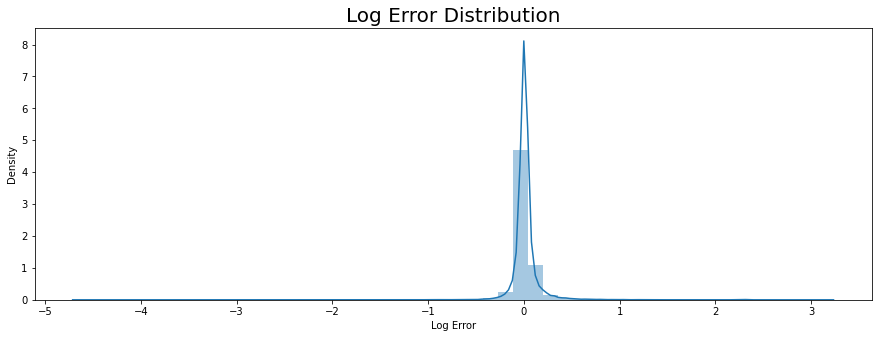

In [7]:
plt.figure(figsize=(15,5))
sns.distplot(df.log_error)
plt.title('Log Error Distribution', fontsize=20)
plt.xlabel('Log Error')

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

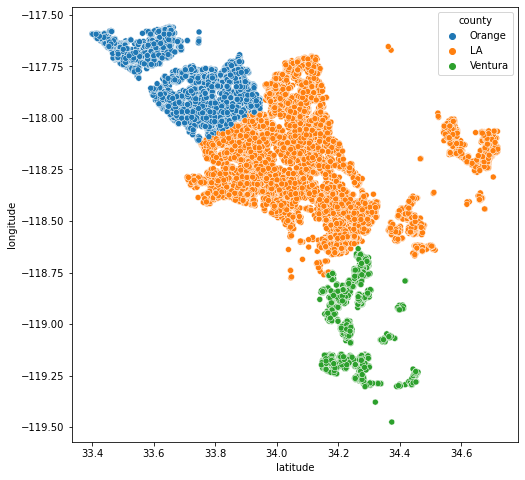

In [17]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x='latitude', y='longitude', data=train, hue='county')

## Data Exploration (train set)

* Before we go exploring our data, we need to impute the train set first, impute function is in the prepare_zillow.py
* this how I impute my data:
    1. fill the quality type null with mean.
    2. drop the rest of null value.

In [48]:
train = prepare_zillow.impute_missing_value_zillow(train)

### Question 1. Does the log error related by location?

<AxesSubplot:xlabel='county', ylabel='log_error'>

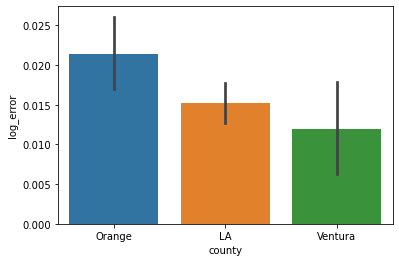

In [49]:
# by county
sns.barplot(x='county', y='log_error', data=train)

<AxesSubplot:xlabel='city', ylabel='log_error'>

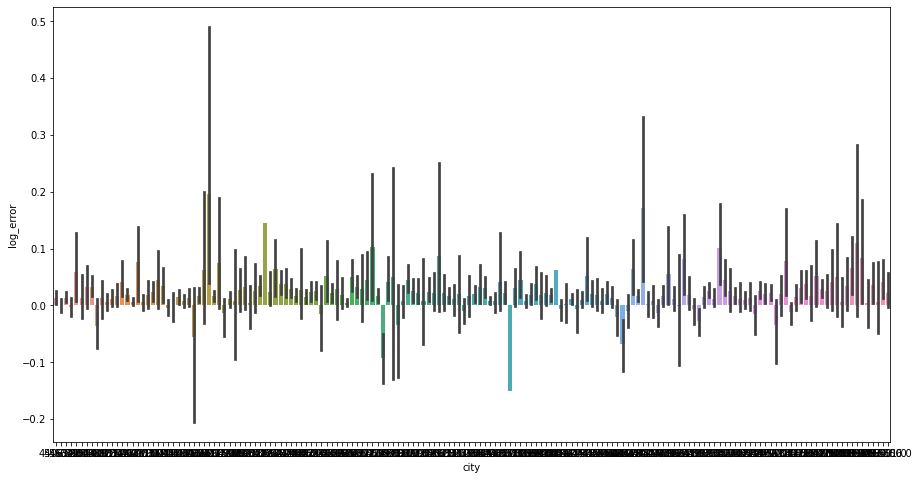

In [28]:
# by city
plt.figure(figsize=(15, 8))
sns.barplot(x='city', y='log_error', data=train)

In [29]:
alpha = 0.05

f_county, p_county = stats.f_oneway(train[train['county'] == 'LA'].log_error,
                                    train[train['county'] == 'Orange'].log_error,
                                    train[train['county'] == 'Ventura'].log_error)

if p_county < alpha:
    print('We reject the null hypothesis. The log_error has a signigicantly difference in those three counties.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis. The log_error has a signigicantly difference in those three counties.


In [79]:
alpha = 0.05

corr_city, p_city = stats.pearsonr(train.city, train.log_error)

if p_city < alpha:
    print("We reject the null hypothesis. City has a correlationship with log error.")
else:
    print("We fail to reject the null.")

We reject the null hypothesis. City has a correlationship with log error.


### Answer 1: 

* Location does have correlation with log error.

### Question  2. Why orange county has the biggest log error? is it because of the house price in orange county is different than average?

<AxesSubplot:xlabel='county', ylabel='house_value'>

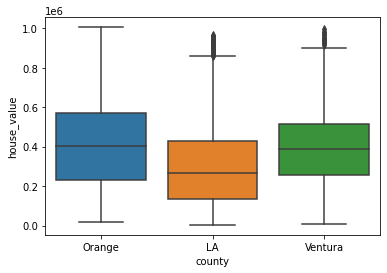

In [50]:
sns.boxplot(data = train, x='county', y='house_value')

In [33]:
alpha = 0.05

t_house_value_orange, p_house_value_orange = stats.ttest_1samp(train[train['county'] == 'Orange'].house_value,
                                 train['house_value'].mean())

if (p_house_value_orange/2 < alpha) & (t_house_value_orange > 0):
    print('We reject the null hypothesis. Orange county average house price is higher than overall average house price.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis. Orange county average house price is higher than overall average house price.


### Answer 2:

* Orange county average house price is higher than overall average house price.

### Question 3. If the Orange county average price could impact log error, what about the relationship overall house value and log error?

<AxesSubplot:xlabel='house_value', ylabel='log_error'>

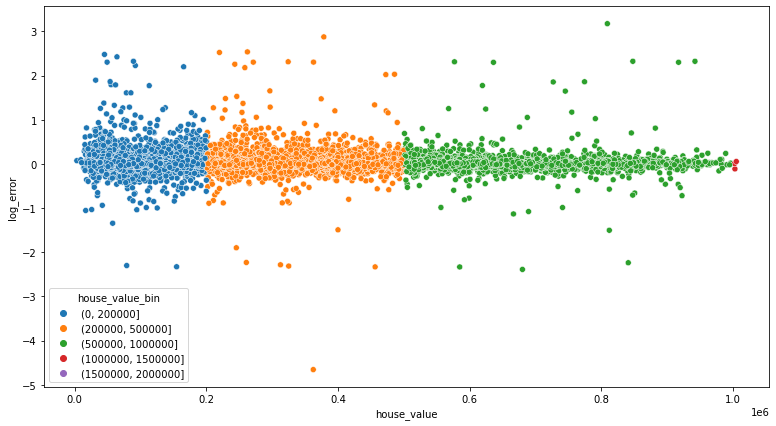

In [51]:
train['house_value_bin'] = pd.cut(train.house_value, [0, 200_000, 500_000, 100_0000,150_0000,200_0000])

plt.figure(figsize=(13, 7))
sns.scatterplot(x='house_value', y='log_error', data=train, hue='house_value_bin')

In [80]:
alpha = 0.05

corr, p = stats.pearsonr(train.house_value, train.log_error)

if p < alpha:
    print("We reject the null hypothesis. The overall house value has correlation with log errror.")
else:
    print("We fail to reject the null.")

We reject the null hypothesis. The overall house value has correlation with log errror.


### Answer 3:

* The overall house value has correlation with log errror.

### Question 4. Is there any relationship between quality type, square feet, room count, house age and log error?

<AxesSubplot:xlabel='age', ylabel='log_error'>

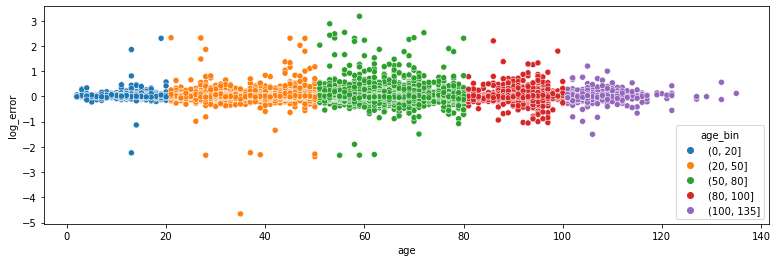

In [72]:
# age and log error
train['age_bin'] = pd.cut(train.age, [0, 20, 50, 80,100,135])
plt.figure(figsize=(13, 4))
sns.scatterplot(x='age', y='log_error', data=train, hue='age_bin')

<AxesSubplot:xlabel='finished_square_ft', ylabel='log_error'>

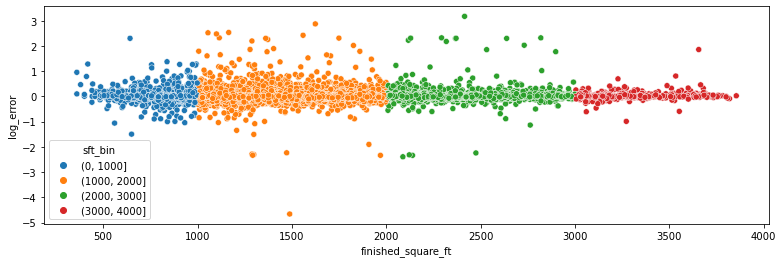

In [73]:
# square feet and log error
train['sft_bin'] = pd.cut(train.finished_square_ft, [0, 1000, 2000, 3000,4000])
plt.figure(figsize=(13, 4))
sns.scatterplot(x='finished_square_ft', y='log_error', data=train, hue='sft_bin')

<AxesSubplot:xlabel='room_count', ylabel='log_error'>

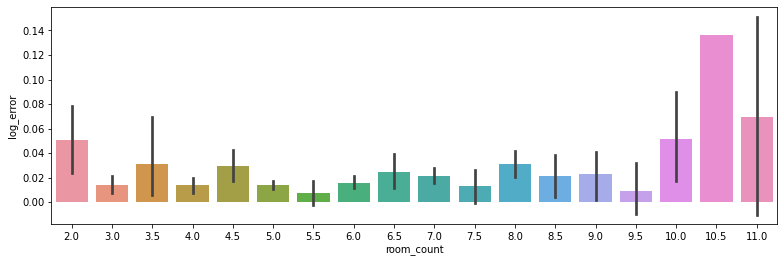

In [75]:
# room count and log error
plt.figure(figsize=(13, 4))
sns.barplot(x='room_count', y='log_error', data=train)

<AxesSubplot:xlabel='log_error', ylabel='quality_type'>

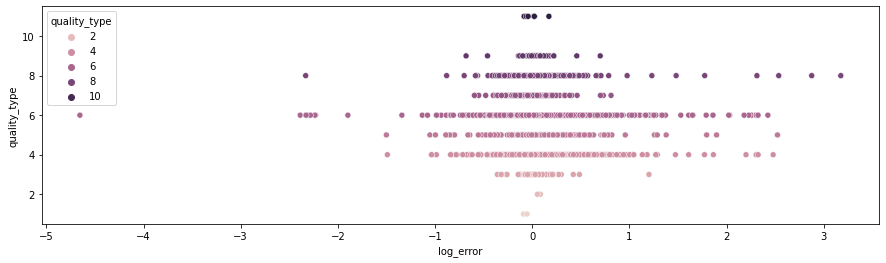

In [78]:
# quality type and log error
plt.figure(figsize=(15, 4))
sns.scatterplot(x='log_error', y='quality_type', data=train, hue='quality_type')

* Satistic test for quality type, square feet, room count, house age and log error are all fail to reject the null.

### Answer 4:

* Even we can see some kind of relationship quality type, square feet, room count, house age and log error, but all the statistic test results are fail to reject the null.

## Exploration Summary:

* Location and price are definitely related to log error. Quality type, square feet, room count, house age are not meet our confident level with the statistic tests. 
* Therefore, the clusters I will create are:
    1. location: latitude, longitude, city, county.
    2. house size and age: finished_square_ft, lot_square_ft, room_count, age.
    3. price: structure_value, house_value, land_value.

## Clustering

In [83]:
# split data

x_train = train[['finished_square_ft','latitude','longitude','lot_square_ft','city',
                 'structure_value','house_value','land_value','age','room_count']]
y_train = train[['log_error']]

validate = prepare_zillow.impute_missing_value_zillow(validate)
x_validate = validate[['finished_square_ft','latitude','longitude','lot_square_ft','city',
                       'structure_value','house_value','land_value','age','room_count']]
y_validate = validate[['log_error']]

test = prepare_zillow.impute_missing_value_zillow(test)
x_test = test[['finished_square_ft','latitude','longitude','lot_square_ft','city',
               'structure_value','house_value','land_value','age','room_count']]
y_test = test[['log_error']]

# get dummy variables for county
county_dummies_train = pd.get_dummies(train['county']) 
county_dummies_validate = pd.get_dummies(validate['county'])
county_dummies_test = pd.get_dummies(test['county'])

In [84]:
# scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns, index=x_train.index)

x_validate_scaled = scaler.transform(x_validate) 
x_test_scaled = scaler.transform(x_test)

x_validate_scaled = pd.DataFrame(x_validate_scaled, columns=x_validate.columns, index=x_validate.index) 
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns, index=x_test.index)

x_train_scaled_with_dummy = pd.concat([x_train_scaled,county_dummies_train],axis=1)
x_validate_scaled_with_dummy = pd.concat([x_validate_scaled,county_dummies_validate],axis=1)
x_test_scaled_with_dummy = pd.concat([x_test_scaled,county_dummies_test],axis=1)

### Cluster 1 : location (latitude, longitude, city, LA, Orange, Ventura)

In [85]:
x1 = x_train_scaled_with_dummy[['latitude', 'longitude', 'city', 'LA', 'Orange', 'Ventura']]

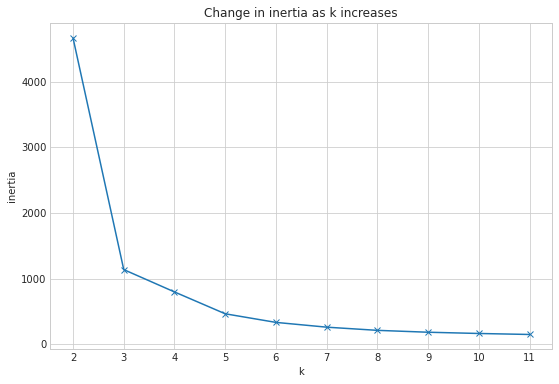

In [86]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(x1).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

#### K = 3

In [87]:
kmeans1 = KMeans(n_clusters=3)
kmeans1.fit(x1)

cluster_location = kmeans1.predict(x1)
x_train_scaled_with_dummy['claster_location'] = cluster_location

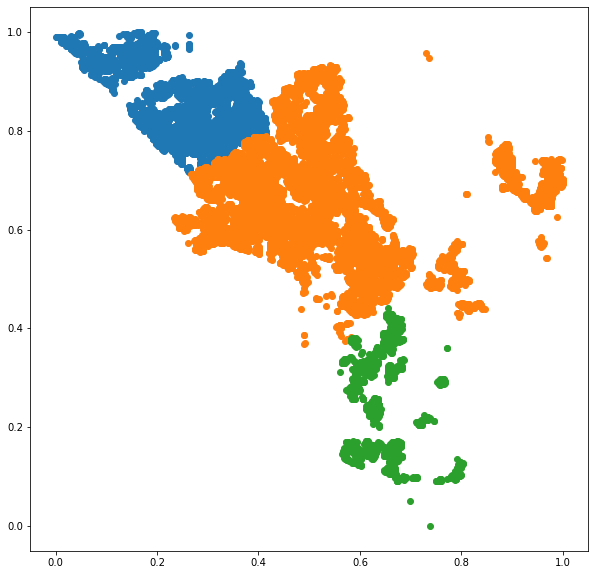

In [88]:
plt.figure(figsize=(10, 10))

for cluster_n in x_train_scaled_with_dummy.claster_location.sort_values().unique():
    plt.scatter(x_train_scaled_with_dummy[x_train_scaled_with_dummy.claster_location == 
                                          cluster_n].latitude, 
                x_train_scaled_with_dummy[x_train_scaled_with_dummy.claster_location == cluster_n].longitude, 
                label=f'cluster_{cluster_n}')

### Cluster 2 : house size and age (finished_square_ft, lot_square_ft, room_count, age)

In [89]:
x2 = x_train_scaled_with_dummy[['finished_square_ft', 'lot_square_ft', 'room_count', 'age']]

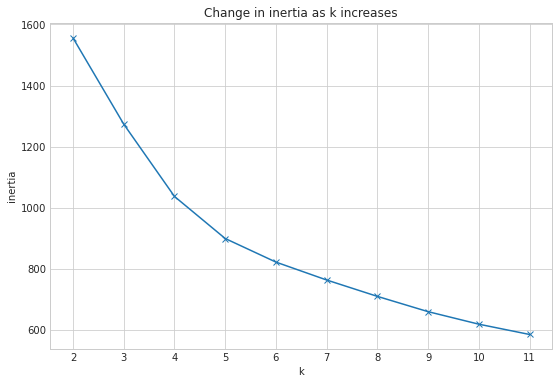

In [90]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(x2).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

#### k = 5

In [91]:
kmeans2 = KMeans(n_clusters=5)
kmeans2.fit(x2)

cluster_size_age = kmeans2.predict(x2)
x_train_scaled_with_dummy['claster_size_age'] = cluster_size_age

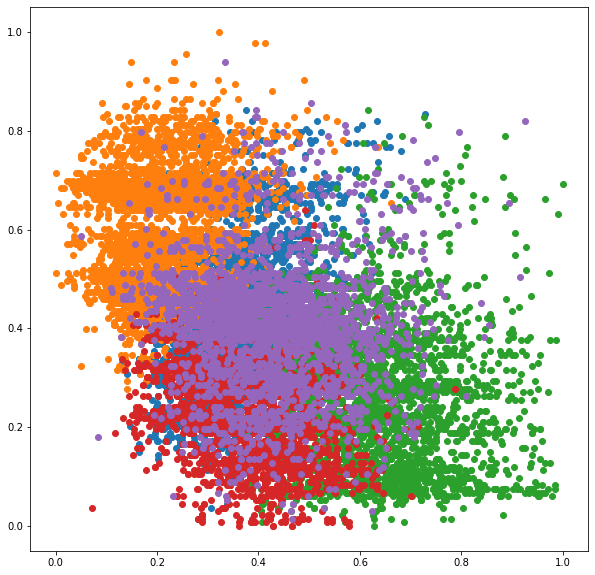

In [92]:
plt.figure(figsize=(10, 10))

for cluster_n in x_train_scaled_with_dummy.claster_size_age.sort_values().unique():
    plt.scatter(x_train_scaled_with_dummy[x_train_scaled_with_dummy.claster_size_age == 
                                          cluster_n].finished_square_ft, 
                x_train_scaled_with_dummy[x_train_scaled_with_dummy.claster_size_age == cluster_n].age, 
                label=f'cluster_{cluster_n}')

### Cluster 3 : price (structure_value, house_value, land_value)

In [93]:
x3 = x_train_scaled_with_dummy[['structure_value', 'house_value','land_value']]

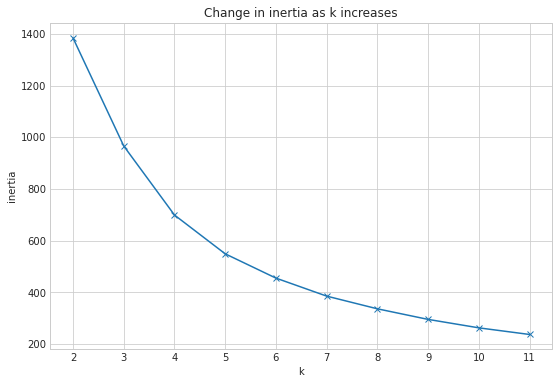

In [94]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(x3).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

#### k = 4

In [95]:
kmeans3 = KMeans(n_clusters=4)
kmeans3.fit(x3)

cluster_price = kmeans3.predict(x3)
x_train_scaled_with_dummy['claster_price'] = cluster_price

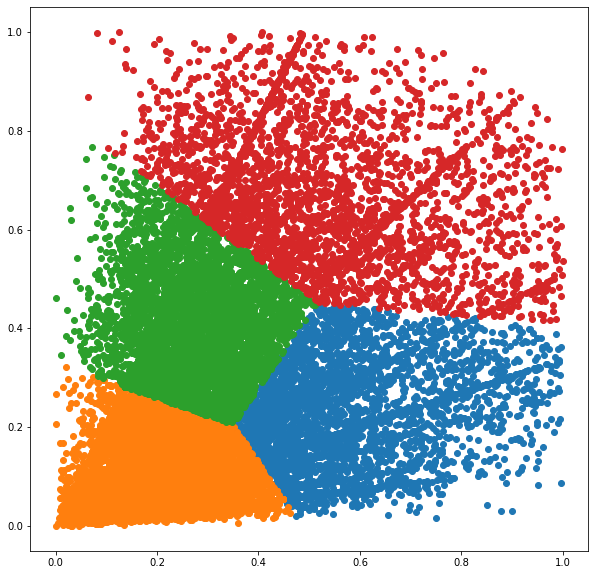

In [96]:
plt.figure(figsize=(10, 10))

for cluster_n in x_train_scaled_with_dummy.claster_price.sort_values().unique():
    plt.scatter(x_train_scaled_with_dummy[x_train_scaled_with_dummy.claster_price == 
                                          cluster_n].structure_value, 
                x_train_scaled_with_dummy[x_train_scaled_with_dummy.claster_price == cluster_n].land_value, 
                label=f'cluster_{cluster_n}')

## Feature Engineering

* From the pre-work evaluation, the best method is RFE (Recursive Feature Elimination)

In [120]:
# get dummies for clusters
x_train_scaled_with_dummy = pd.get_dummies(x_train_scaled_with_dummy, columns=['claster_location'])
x_train_scaled_with_dummy = pd.get_dummies(x_train_scaled_with_dummy, columns=['claster_size_age'])
x_train_scaled_with_dummy = pd.get_dummies(x_train_scaled_with_dummy, columns=['claster_price'])

### RFE

In [130]:
lm = LinearRegression()
rfe = RFE(lm, n_features_to_select=5)
rfe.fit(x_train_scaled_with_dummy,y_train)  
feature_mask = rfe.support_
rfe_feature = x_train_scaled_with_dummy.iloc[:,feature_mask].columns.tolist()
rfe_feature

['finished_square_ft', 'latitude', 'city', 'structure_value', 'room_count']

# Modeling

Because house value is a continuous variable, so I will use five different Regression machine learning models to fit the train. Those five models will use same features but different algorithms. Then evaluate on validate set for overfit and pick the best model on the test set.

The metrics I will use are RMSE (Root Mean Squared Error). RMSE is the most commonly used metric for regression model also it has the same unit as our target value. 

* Features will be used are: 

    'finished_square_ft', 'latitude', 'city', 'structure_value', 'room_count'.

(array([1.0000e+00, 0.0000e+00, 5.0000e+00, 5.0000e+00, 2.9000e+01,
        1.7357e+04, 4.7110e+03, 5.6000e+01, 2.8000e+01, 6.0000e+00]),
 array([-4.65542038, -3.87230954, -3.08919871, -2.30608787, -1.52297704,
        -0.73986621,  0.04324463,  0.82635546,  1.6094663 ,  2.39257713,
         3.17568797]),
 <BarContainer object of 10 artists>)

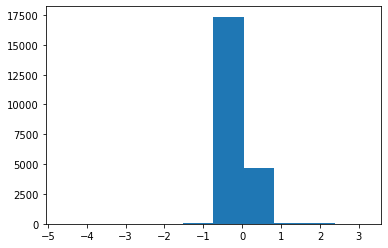

In [101]:
# Visualize my target variable
plt.hist(train.log_error)

## Baseline
* Set up a baseline on train and validate set, baseline value is the mean of log error on the train set.
* I will use RMSE (Root Mean Squared Error) to evaluate my baseline.

In [103]:
#Establish baselines for the train and validation subsets
baseline = train.log_error.mean()

train['baseline'] = baseline
validate['baseline'] = baseline

train_rmse = sqrt(mean_squared_error(train.log_error, train.baseline))
validate_rmse = sqrt(mean_squared_error(validate.log_error, validate.baseline))

print('Train baseline RMSE: {}.'.format(train_rmse))
print('Validation baseline RMSE: {}.'.format(validate_rmse))

Train baseline RMSE: 0.16038712270931066.
Validation baseline RMSE: 0.16086423042849432.


## Fit models on train set

### Features:

1. finished_square_ft
2. latitude
3. city
4. structure_value
5. room_count

### Models:
    
1. Linear Regression
2. Lasso-Lars
3. TweedieRegressor
4. 2nd degree Polynomial
5. Interaction only polynomial

In [131]:
x_train_rfe = x_train_scaled_with_dummy[['finished_square_ft', 'latitude', 'city', 'structure_value', 'room_count']]

predictions_train_rfe_model = pd.DataFrame({'actual': train.log_error})
predictions_train_rfe_model['baseline'] = baseline

lm = LinearRegression()
lm.fit(x_train_rfe, y_train)
predictions_train_rfe_model['lm'] = lm.predict(x_train_rfe)

lars = LassoLars(alpha=1.0)
lars.fit(x_train_rfe, y_train)
predictions_train_rfe_model['lasso_lars'] = lars.predict(x_train_rfe)

glm = TweedieRegressor(power=0, alpha=1)
glm.fit(x_train_rfe, y_train)
predictions_train_rfe_model['glm'] = glm.predict(x_train_rfe)

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(x_train_rfe)
x_train_rfe_poly = pd.DataFrame(
    poly.transform(x_train_rfe),
    columns=poly.get_feature_names(x_train_rfe.columns),
    index=train.index)
lm1 = LinearRegression()
lm1.fit(x_train_rfe_poly, y_train)
x_train_poly = poly.transform(x_train_rfe)
predictions_train_rfe_model['polynomial_degree_2'] = lm1.predict(x_train_rfe_poly)

poly1 = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly1.fit(x_train_rfe)
x_train_rfe_poly1 = pd.DataFrame(
    poly1.transform(x_train_rfe),
    columns=poly1.get_feature_names(x_train_rfe.columns),
    index=train.index)
lm1.fit(x_train_rfe_poly1, y_train)
x_train_poly1 = poly1.transform(x_train_rfe)
predictions_train_rfe_model['polynomial_only_interaction'] = lm1.predict(x_train_rfe_poly1)
predictions_train_rfe_model.head()

,actual,baseline,lm,lasso_lars,glm,polynomial_degree_2,polynomial_only_interaction
14844,-0.013522,0.016592,0.034459,0.016592,0.016922,0.034883,0.030484
43572,0.085926,0.016592,0.008126,0.016592,0.016495,0.012845,0.008414
17055,0.010107,0.016592,0.013208,0.016592,0.016526,0.001956,0.008534
7546,0.085135,0.016592,0.016927,0.016592,0.016571,0.020007,0.017519
6558,-0.015197,0.016592,0.015707,0.016592,0.016592,0.015967,0.018387


In [132]:
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(predictions_train_rfe_model.actual, y_predicted))
predictions_train_rfe_model.apply(calculate_rmse).sort_values()

actual                         0.000000
polynomial_degree_2            0.159977
polynomial_only_interaction    0.160071
lm                             0.160190
glm                            0.160379
baseline                       0.160387
lasso_lars                     0.160387
dtype: float64

## Fit top three models on validate set

#### Top three models are:
    1. 2nd degree polynomial
    2. Interaction only polynomial
    3. Linear Regression

In [133]:
x_validate_rfe = x_validate_scaled_with_dummy[['finished_square_ft', 'latitude', 'city', 'structure_value', 'room_count']]
predictions_validate_rfe_model = pd.DataFrame({'actual': validate.log_error})

lm.fit(x_train_rfe, y_train)
predictions_validate_rfe_model['lm'] = lm.predict(x_validate_rfe)

lm1 = LinearRegression()
lm1.fit(x_train_rfe_poly, y_train)
predictions_validate_rfe_model['polynomial_degree_2'] = lm1.predict(poly.transform(x_validate_rfe))

lm1.fit(x_train_rfe_poly1, y_train)
predictions_validate_rfe_model['polynomial_only_interaction'] = lm1.predict(poly1.transform(x_validate_rfe))
predictions_validate_rfe_model.head()

,actual,lm,polynomial_degree_2,polynomial_only_interaction
1103,0.037393,0.022127,0.019414,0.019865
7910,0.004254,0.016527,0.009301,0.015260
1339,0.005471,0.005074,0.007546,0.002173
45475,-0.006522,0.013702,0.003531,0.010953
105,0.007143,0.020677,0.014928,0.020042


In [134]:
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(predictions_validate_rfe_model.actual, y_predicted))
predictions_validate_rfe_model.apply(calculate_rmse).sort_values()

actual                         0.000000
polynomial_only_interaction    0.160489
polynomial_degree_2            0.160579
lm                             0.160603
dtype: float64

## Fit the best model on test set : Interaction only polynomial

In [135]:
x_test_rfe = x_test_scaled_with_dummy[['finished_square_ft', 'latitude', 'city', 'structure_value', 'room_count']]

poly_test = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly_test.fit(x_train_rfe)
x_train_rfe_poly = pd.DataFrame(poly_test.transform(x_train_rfe),
                            columns=poly_test.get_feature_names(x_train_rfe.columns),index=train.index)
lm_test_rfe = LinearRegression()
lm_test_rfe.fit(x_train_rfe_poly, y_train)

x_test_rfe_poly = poly_test.transform(x_test_rfe)
test_predictions = lm_test_rfe.predict(x_test_rfe_poly)
test_actual = test.log_error

In [136]:
# RMSE
sqrt(mean_squared_error(test_actual, test_predictions))

0.172105230238343

### Best model performance

In [137]:
print('RMSE for 2nd Degree Polynomial model on the train dataset: {}'.format(sqrt(mean_squared_error(predictions_train_rfe_model.actual, predictions_train_rfe_model.polynomial_only_interaction))))
print('RMSE for 2nd Degree Polynomial model on the validate dataset: {}'.format(sqrt(mean_squared_error(predictions_validate_rfe_model.actual, predictions_validate_rfe_model.polynomial_only_interaction))))
print('RMSE for 2nd Degree Polynomial model on the test dataset: {}'.format(sqrt(mean_squared_error(test_actual, test_predictions))))

RMSE for 2nd Degree Polynomial model on the train dataset: 0.1600713236379127
RMSE for 2nd Degree Polynomial model on the validate dataset: 0.16048897338191598
RMSE for 2nd Degree Polynomial model on the test dataset: 0.172105230238343


### Baseline performance

In [117]:
print('Train baseline RMSE: {}.'.format(train_rmse))
print('Validation baseline RMSE: {}.'.format(validate_rmse))

Train baseline RMSE: 0.16038712270931066.
Validation baseline RMSE: 0.16086423042849432.


Text(0.5, 1.0, 'Actual vs predicted log error with polynomial_only_interaction')

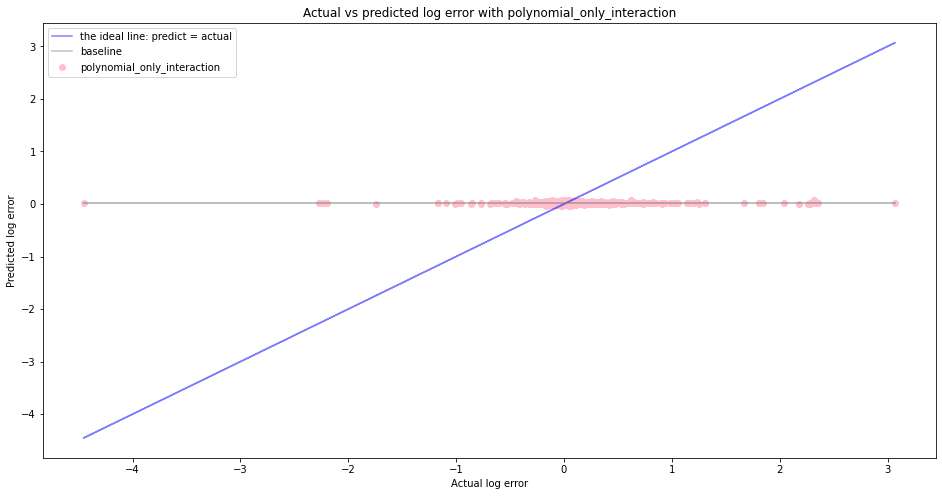

In [138]:
predictions_test_rfe = pd.DataFrame({'actual': test.log_error})
predictions_test_rfe['polynomial_only_interaction'] = lm_test_rfe.predict(poly_test.transform(x_test_rfe))
predictions_test_rfe['baseline'] = baseline

plt.figure(figsize=(16,8))

plt.plot(predictions_test_rfe['actual'], predictions_test_rfe['actual'], alpha=0.5,
         color='blue', label='the ideal line: predict = actual')
plt.plot(predictions_test_rfe['actual'], predictions_test_rfe['baseline'], alpha=0.5,
         color='gray', label='baseline')

plt.scatter(predictions_test_rfe['actual'], predictions_test_rfe['polynomial_only_interaction'],
            color='pink', label='polynomial_only_interaction')

plt.legend()
plt.xlabel('Actual log error')
plt.ylabel('Predicted log error')
plt.title('Actual vs predicted log error with polynomial_only_interaction')

### Expectation:

According to the test result, I expect there will be a 0.17 log error for my future prediction if the data souce has no major change.

# Conclusion

## Summary

By analyzing the key drivers of the majority of Zillow single house value of 2017, we create three clusters to explore and built a interaction only polynomisl regression model with the top five attributes ('finished_square_ft', 'latitude', 'city', 'structure_value', 'room_count') from select K best to predict the log error. The RMSE for the test set is 0.17. The best model on the test set doesn't beat the baseline 0.16.

## Recommendations

* This project is very similar to the regression project, the only difference is we added clusters exploration. But from the RFE result, non of the clusters are useful. Therefore, I will say that maybe clustering is not the best approach for the Zillow data. 
* Also linear regression model performance is very poor. We can prove that the features we explore are related to log error, but the test result looks not good. It may because the linear regression models are not the best fit for non-linear data like Zillow. We need to use different types of model to predict the log error.
* There are a lot of missing data for pool and garage, it will be the best to collect as much data as possible.

## Next Steps: 

1. Even clustering seems useless for this data, I still want to explore more about different clusters I can built to see if it's really not helping at all.

2. Since we already know that linear regression models don't perform well on Zillow data, I would like to built different types of model to have a better prediction of the target viarable.

### Github link:
